# April fool's Contest on Codeforces Analysis
After ranking much higher on Fool's contest and noticing that tourist got top score even in the joke contest, I wanted to answer some interesting questions:
1. Who participated in the contest (population)?
2. Correlation between competitive rating and rank?

Let's get to it!

First things first, let's pull up our data using [Codeforces API](https://codeforces.com/apiHelp/objects#Contest)

In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
contestId = 1331
r = requests.get(f"https://codeforces.com/api/contest.standings?contestId={contestId}")
parsed_data = json.loads(r.content)

parsed_data.keys()

dict_keys(['status', 'result'])

In [3]:
len(parsed_data['result']['rows'])

11391

Let's just find ranks for now. The rank 1 would be tourist, so he should be the first elem in the list

In [4]:
parsed_data['result']['rows'][0]

{'party': {'contestId': 1331,
  'members': [{'handle': 'tourist'}],
  'participantType': 'CONTESTANT',
  'ghost': False,
  'startTimeSeconds': 1585751700},
 'rank': 1,
 'points': 8.0,
 'penalty': 231,
 'successfulHackCount': 0,
 'unsuccessfulHackCount': 0,
 'problemResults': [{'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 190},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 3589},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 1215},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 1276},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 1768},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissionTimeSeconds': 486},
  {'points': 1.0,
   'rejectedAttemptCount': 0,
   'type': 'FINAL',
   'bestSubmissio

After taking a closer look at the data, we see that this object doesn't actually contain user's ranking. Since the contest was unrated, contest.ratingChanges also returns FAIL status, which is unfortunate since we cannot easily get their ranks. Two solutions to this that come to mind:

1. Look up each users rating individually
2. Look up last Div 1, 2, 3 contests, request contest.ratingChanges from them and remove users that didn't take one of them. We should get a pretty good approximation and, hopefully, a good portion of ratings.

I'll try the second approach since I don't think that asking 11,391 requests is a good idea

Edit: After reading API documentation, I've noticed the user.ratedList method - "Returns the list users who have participated in at least one rated contest". Good. If you suspect that you are reinventing a bicycle, you probably are. 

In [5]:
ra = requests.get("https://codeforces.com/api/user.ratedList?activeOnly=true") #activeOnly=true shows users active this month
ra_parsed_data = json.loads(ra.content)
data = ra_parsed_data['result']

In [6]:
data[0]

{'lastName': 'Korotkevich',
 'country': 'Belarus',
 'lastOnlineTimeSeconds': 1585780139,
 'city': 'Gomel',
 'rating': 3669,
 'friendOfCount': 24180,
 'titlePhoto': '//userpic.codeforces.com/422/title/50a270ed4a722867.jpg',
 'handle': 'tourist',
 'avatar': '//userpic.codeforces.com/422/avatar/2b5dbe87f0d859a2.jpg',
 'firstName': 'Gennady',
 'contribution': 182,
 'organization': 'ITMO University',
 'rank': 'legendary grandmaster',
 'maxRating': 3739,
 'registrationTimeSeconds': 1265987288,
 'maxRank': 'legendary grandmaster'}

In [7]:
def get_active_users():
    r = requests.get("https://codeforces.com/api/user.ratedList?activeOnly=true")
    parsed_data = json.loads(r.content)
    
    if parsed_data['status'] == "OK":
        data = parsed_data['result']
        cleaned_data = {}
        for each in data:
            handle = each['handle']
            rating = each['rating']
            cleaned_data[handle] = rating
        return cleaned_data
    else:
        return -1

cleaned_active = get_active_users()

In [8]:
def get_contest_scoreboard(contestId=1331):
    r = requests.get(f"https://codeforces.com/api/contest.standings?contestId={contestId}")
    parsed_data = json.loads(r.content)
    
    if parsed_data['status'] == "OK":
        data = parsed_data['result']['rows']
        cleaned_data = {}
        for each in data:
            handle = each['party']['members'][0]['handle']
            rank = each['rank']
            cleaned_data[handle] = rank
        return cleaned_data
    else:
        return -1

cleaned_scoreboard = get_contest_scoreboard()

In [9]:
len(cleaned_active)

36818

In [10]:
cleaned_active['RMILKA']

1715

In [11]:
len(cleaned_scoreboard)

11391

In [12]:
cleaned_scoreboard['RMILKA']

390

Good. My rating is indeed 1715, and I got 390th place in the contest, so matches out. Notice that during last month we had 36818 users, and 11391 participated in the last contest. Let's see how many of those participated

In [13]:
len(set(cleaned_active.keys()).intersection(set(cleaned_scoreboard.keys())))

8597

Not bad, we have rating info for 8597 out of 11391 users

In [14]:
good_handles = set(cleaned_active.keys()).intersection(set(cleaned_scoreboard.keys()))

In [18]:
combined = []
for handle in good_handles:
    combined.append({'handle': handle,
                    'rating':cleaned_active[handle],
                    'rank':cleaned_scoreboard[handle]})

In [20]:
df = pd.DataFrame(data=combined)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c3d5690>]],
      dtype=object)

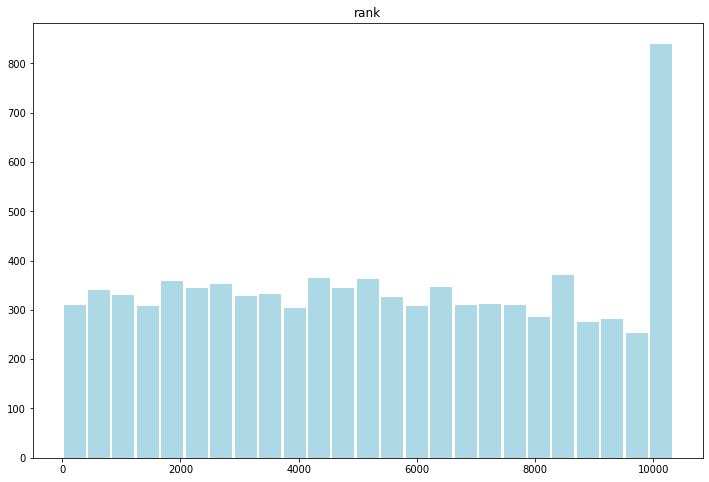

In [37]:
df.hist(column='rank', bins=25, grid=False, figsize=(12,8), color='#add8e6', zorder=2, rwidth=0.9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1149c4790>]],
      dtype=object)

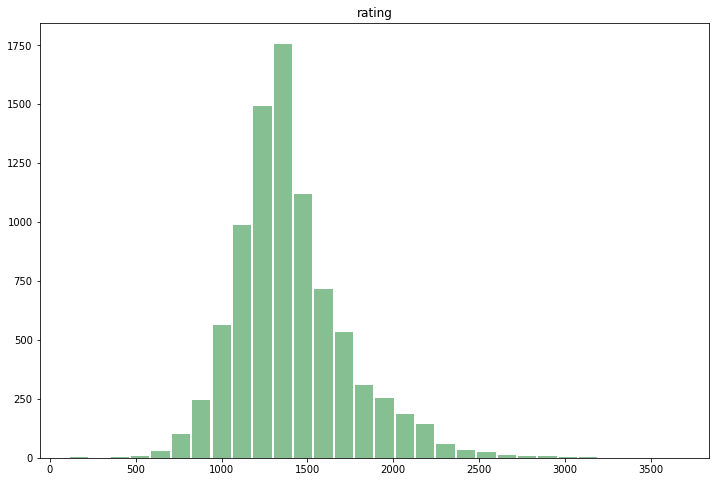

In [28]:
df.hist(column='rating', bins=30, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

## Looks good. 
Now let's find correlation coefficient. And visualize

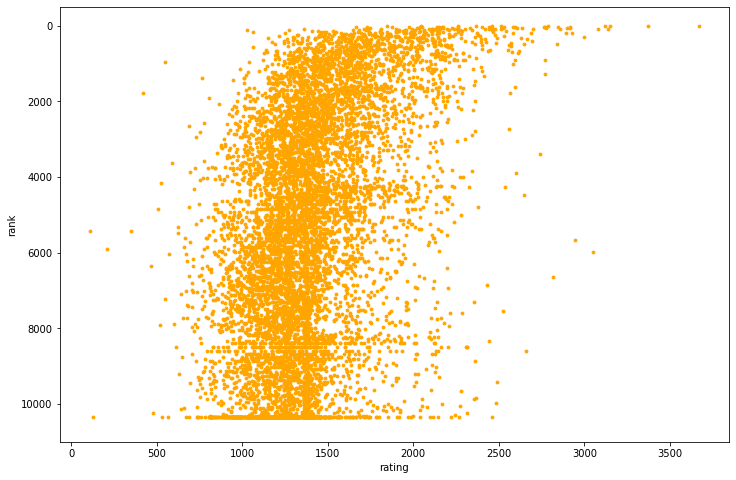

In [75]:
df.plot.scatter(x='rating', y='rank', ylim=(11000,-500), 
                s=8, marker='o', color='orange', grid=False, figsize=(12,8))

In [78]:
column_1 = -df["rating"]  # negative rating to make positive correlation (like on the plot)
column_2 = df["rank"]
correlation = column_1.corr(column_2)
print(correlation)

0.40823313359351604


In [97]:
selected = df[df["rank"] < 1000]  # Top 1000 in the contest

column_1 = -selected["rating"]  # negative rating to make positive correlation (like on the plot)
column_2 = selected["rank"]
correlation = column_1.corr(column_2)
print(correlation)

0.41343970806563


In [100]:
selected = df[df["rating"] > 1500] # People with rating more than 1500

column_1 = -selected["rating"]  # negative rating to make positive correlation (like on the plot)
column_2 = selected["rank"]
correlation = column_1.corr(column_2)
print(correlation)

0.20462939928887686


## Hold on!
#### Something surprising
So the overall correlation between the rank and rating is weak-moderate with correlation of about ~0.41
Also if we look at the correlation for top 1000 people on the leaderboard, they also have the same correlation ~0.41
HOWEVER, if we limit to only those with rating >1500, the correlation becomes very weak! Which means that once you are at least decent at CP, you were on the same level field as people 
you contest performance 
meant almost nothing for April Fool's contest.

This will be the end of my analysis, feel free to try things out and lmk if u find anything interesting!

Cheers!